## Problem Statement

We have been given a PDE: $u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)=0,\quad x\in[-10,10]$
and boundary condition: $u(x)=\hat{u}(x)$

- Independent variables: x (input)
- Dependent variables: u (outputs)


We have to find out u(x) for all x in range [-10,10] 


When we solved this problem analytically, we found the solution: $u(x) = \sin(0.7x)+\cos(1.5x)-0.1x$


Our residual is $f = u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 1 (x)
and #outputs = 1 (u)

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 3 hidden layer with 50 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(1,50)
        self.hidden_layer2 = nn.Linear(50,50)
        self.hidden_layer3 = nn.Linear(50,50)
        self.output_layer = nn.Linear(50,1)

    def forward(self, x):
        inputs = x # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out) ## For regression, no activation is used in output layer
        return output

## PINN

In [4]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [5]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x, net):
    u = net(x) # the dependent variable u is given by the network based on independent variables x,t
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    pde = u_xx + 0.49*torch.sin(0.7*x) + 2.25*torch.cos(1.5*x)
    return pde

In [6]:
## Data from Boundary Conditions
## BC just gives us datapoints for training

# BC tells us that for any x=-10 or 10, the value of u is given by analytical solution
x_bc = np.array([[-10],[10]])
# compute u based on BC
u_bc = np.sin(0.7*x_bc)+np.cos(1.5*x_bc)-0.1*x_bc

In [7]:
def exact_u(x):
    return np.sin(0.7*x)+np.cos(1.5*x)-0.1*x 

In [8]:
### (3) Training / Fitting
iterations = 5000*2
# previous_validation_loss = 99999999.0
T_error1=[]
T_BC1=[]
T_PDE1=[]
Step=[]
for epoch in range(600):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.detach().cpu().numpy())
            Step.append(epoch)
    

[0]-th step loss: 3.6185,  BC: 0.96686, residual: 2.65164
[100]-th step loss: 1.7286,  BC: 0.00005, residual: 1.72851
[200]-th step loss: 1.2255,  BC: 0.00059, residual: 1.22493
[300]-th step loss: 1.3255,  BC: 0.00184, residual: 1.32367
[400]-th step loss: 0.8819,  BC: 0.00122, residual: 0.88066
[500]-th step loss: 0.7689,  BC: 0.00065, residual: 0.76826


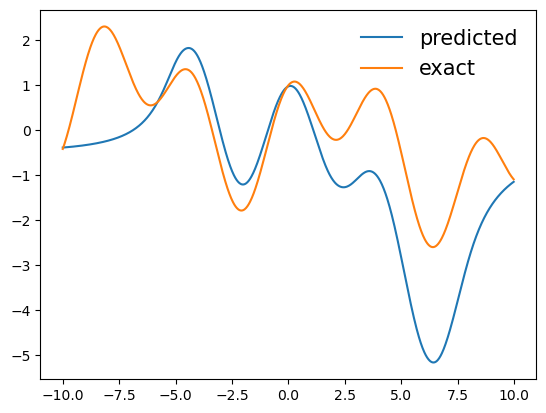

In [9]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

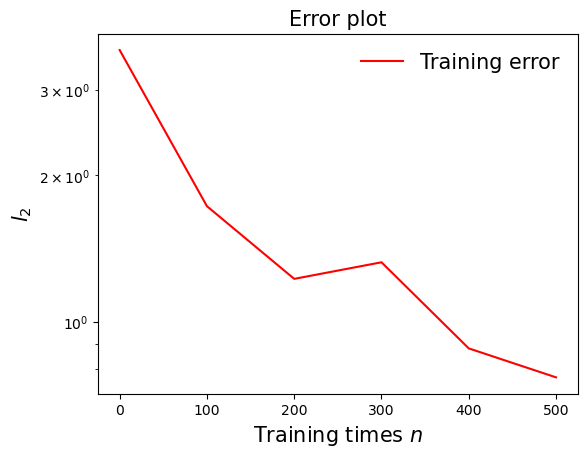

In [10]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [11]:
for epoch in range(600,900):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.detach().cpu().numpy())
            Step.append(epoch)

[600]-th step loss: 0.5373,  BC: 0.00113, residual: 0.53619
[700]-th step loss: 0.4736,  BC: 0.00039, residual: 0.47325
[800]-th step loss: 0.4309,  BC: 0.00013, residual: 0.43076


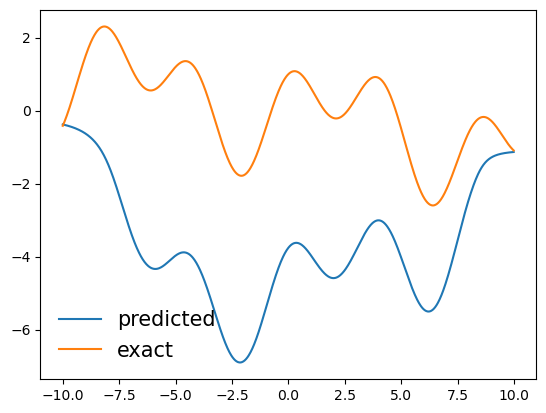

In [12]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

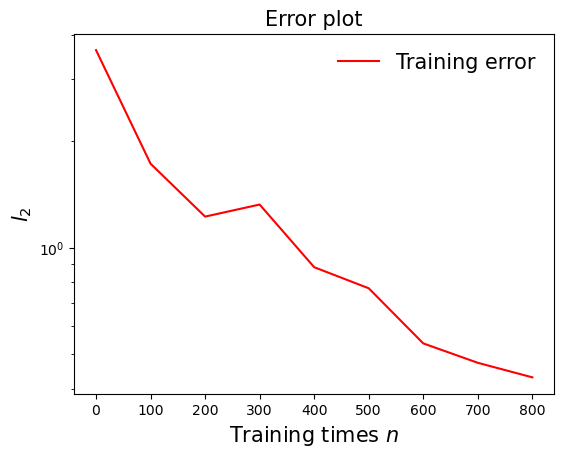

In [13]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [14]:
for epoch in range(900,5000):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.detach().cpu().numpy())
            Step.append(epoch)

[900]-th step loss: 0.1885,  BC: 0.00117, residual: 0.18731
[1000]-th step loss: 0.1752,  BC: 0.00044, residual: 0.17471
[1100]-th step loss: 0.1078,  BC: 0.00030, residual: 0.10754
[1200]-th step loss: 0.1318,  BC: 0.00005, residual: 0.13173
[1300]-th step loss: 0.1295,  BC: 0.00025, residual: 0.12928
[1400]-th step loss: 0.0794,  BC: 0.00014, residual: 0.07924
[1500]-th step loss: 0.0255,  BC: 0.00020, residual: 0.02527
[1600]-th step loss: 0.0174,  BC: 0.00036, residual: 0.01704
[1700]-th step loss: 0.0178,  BC: 0.00041, residual: 0.01735
[1800]-th step loss: 0.0069,  BC: 0.00068, residual: 0.00623
[1900]-th step loss: 0.0080,  BC: 0.00384, residual: 0.00418
[2000]-th step loss: 0.0058,  BC: 0.00003, residual: 0.00578
[2100]-th step loss: 0.0041,  BC: 0.00025, residual: 0.00382
[2200]-th step loss: 0.0082,  BC: 0.00192, residual: 0.00628
[2300]-th step loss: 0.0041,  BC: 0.00013, residual: 0.00395
[2400]-th step loss: 0.0049,  BC: 0.00001, residual: 0.00491
[2500]-th step loss: 0.00

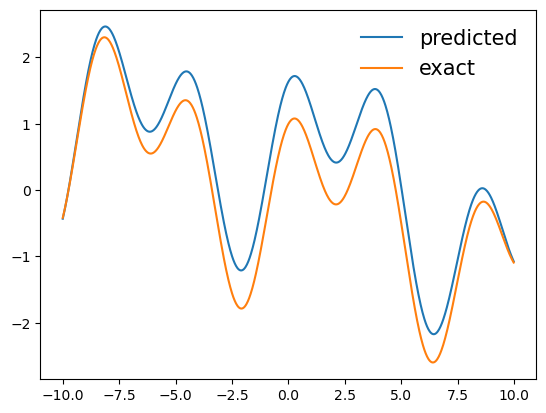

In [15]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

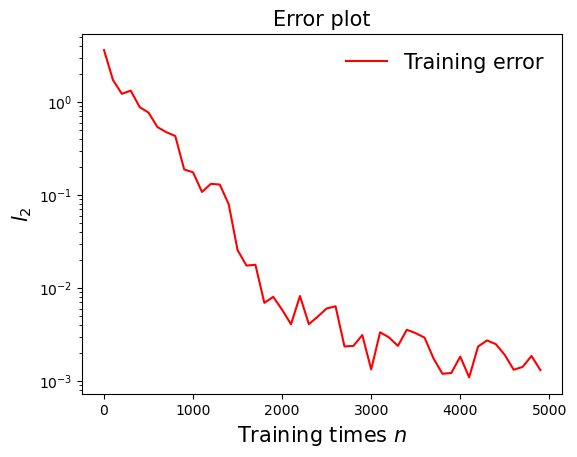

In [16]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [17]:
for epoch in range(5000,iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.detach().cpu().numpy())
            Step.append(epoch)

[5000]-th step loss: 0.0016,  BC: 0.00021, residual: 0.00135
[5100]-th step loss: 0.0009,  BC: 0.00001, residual: 0.00092
[5200]-th step loss: 0.0008,  BC: 0.00015, residual: 0.00069
[5300]-th step loss: 0.0006,  BC: 0.00000, residual: 0.00062
[5400]-th step loss: 0.0008,  BC: 0.00014, residual: 0.00062
[5500]-th step loss: 0.0008,  BC: 0.00013, residual: 0.00068
[5600]-th step loss: 0.0008,  BC: 0.00006, residual: 0.00077
[5700]-th step loss: 0.0015,  BC: 0.00042, residual: 0.00105
[5800]-th step loss: 0.0006,  BC: 0.00017, residual: 0.00046
[5900]-th step loss: 0.0010,  BC: 0.00004, residual: 0.00093
[6000]-th step loss: 0.0007,  BC: 0.00008, residual: 0.00066
[6100]-th step loss: 0.0006,  BC: 0.00008, residual: 0.00049
[6200]-th step loss: 0.0019,  BC: 0.00073, residual: 0.00114
[6300]-th step loss: 0.0005,  BC: 0.00006, residual: 0.00046
[6400]-th step loss: 0.0004,  BC: 0.00009, residual: 0.00033
[6500]-th step loss: 0.0009,  BC: 0.00041, residual: 0.00045
[6600]-th step loss: 0.0

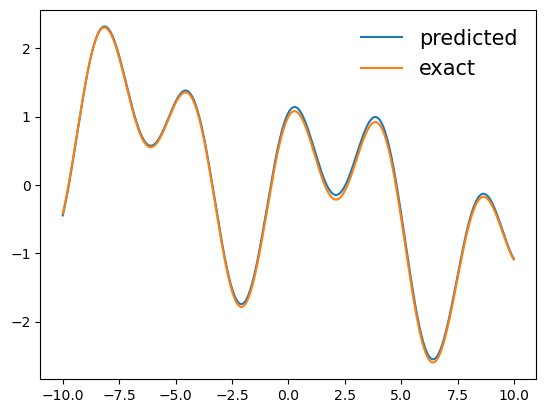

In [18]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

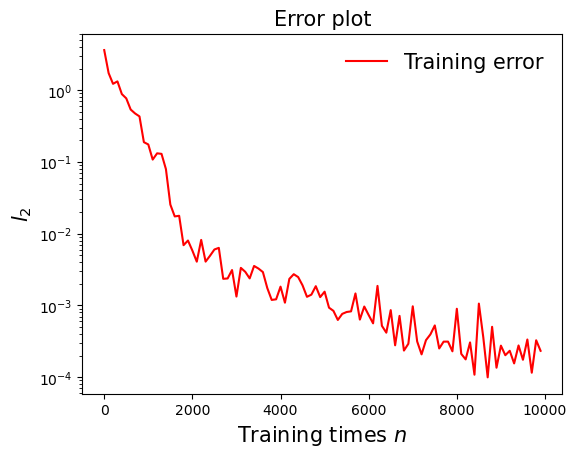

In [19]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

## lbPINN

In [20]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [21]:
# s_f=torch.tensor(0.).float()
# s_bc=torch.tensor(0.).float()

In [22]:
weight = torch.tensor([0.,0.], requires_grad=True, device='cuda:0')

In [24]:
optimizer_weight = torch.optim.Adam([weight], lr=1e-3)

In [25]:
### (3) Training / Fitting
T_error2=[]
T_BC2=[]
T_PDE2=[]
Step=[]
for epoch in range(600):
    optimizer_weight.zero_grad() # to make the gradients zero
    
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = torch.exp(-weight.data[0])*mse_b + torch.exp(-weight.data[1])*mse_f + weight.data[0]+weight.data[1]
    

    
    loss.backward(retain_graph=True) # This is for computing gradients using backward propagation
    optimizer_weight.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    optimizer.zero_grad()
    loss = torch.exp(-weight.data[0])*mse_b + torch.exp(-weight.data[1])*mse_f 
    loss.backward()
    optimizer.step()
    
    loss_sum = mse_b+mse_f

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss_sum, mse_b,mse_f))
            print(weight)
            T_BC2.append(mse_b.detach().cpu().numpy())
            T_PDE2.append(mse_f.detach().cpu().numpy())
            T_error2.append(loss_sum.detach().cpu().numpy())
            Step.append(epoch)

[0]-th step loss: 3.1407,  BC: 0.71942, residual: 2.42130
tensor([0., 0.], device='cuda:0', requires_grad=True)
[100]-th step loss: 1.8242,  BC: 0.00002, residual: 1.82414
tensor([0., 0.], device='cuda:0', requires_grad=True)
[200]-th step loss: 1.5228,  BC: 0.00043, residual: 1.52239
tensor([0., 0.], device='cuda:0', requires_grad=True)
[300]-th step loss: 1.0705,  BC: 0.00050, residual: 1.06996
tensor([0., 0.], device='cuda:0', requires_grad=True)
[400]-th step loss: 0.8933,  BC: 0.00005, residual: 0.89329
tensor([0., 0.], device='cuda:0', requires_grad=True)
[500]-th step loss: 0.6573,  BC: 0.00102, residual: 0.65631
tensor([0., 0.], device='cuda:0', requires_grad=True)


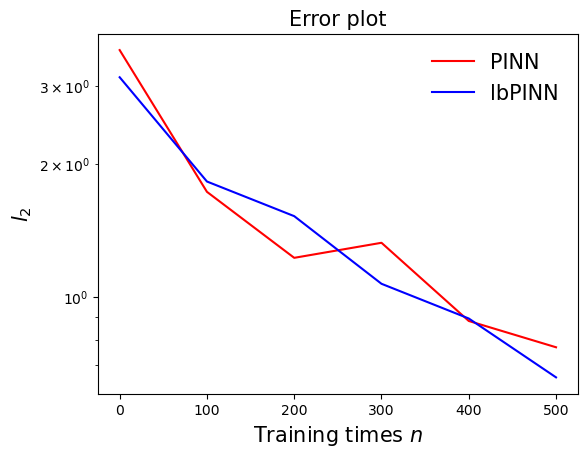

In [26]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1[:len(Step)],'r',label='PINN')
plt.semilogy(Step, T_error2,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

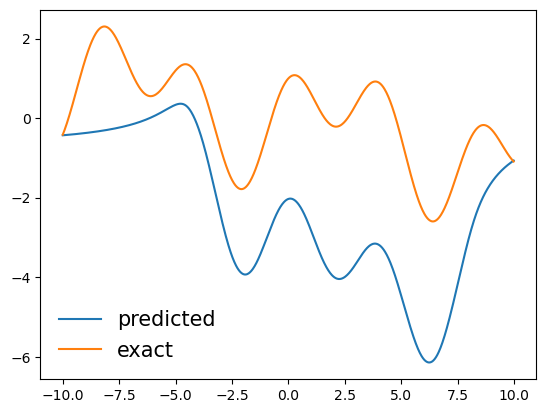

In [27]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [28]:
for epoch in range(600,900):
    optimizer_weight.zero_grad() # to make the gradients zero
    
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = torch.exp(-weight.data[0])*mse_b + torch.exp(-weight.data[1])*mse_f + weight.data[0]+weight.data[1]
    

    
    loss.backward(retain_graph=True) # This is for computing gradients using backward propagation
    optimizer_weight.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    optimizer.zero_grad()
    loss = torch.exp(-weight.data[0])*mse_b + torch.exp(-weight.data[1])*mse_f 
    loss.backward()
    optimizer.step()
    
    loss_sum = mse_b+mse_f

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss_sum, mse_b,mse_f))
            print(weight)
            T_BC2.append(mse_b.detach().cpu().numpy())
            T_PDE2.append(mse_f.detach().cpu().numpy())
            T_error2.append(loss_sum.detach().cpu().numpy())
            Step.append(epoch)

[600]-th step loss: 0.5399,  BC: 0.00102, residual: 0.53889
tensor([0., 0.], device='cuda:0', requires_grad=True)
[700]-th step loss: 0.6074,  BC: 0.00022, residual: 0.60721
tensor([0., 0.], device='cuda:0', requires_grad=True)
[800]-th step loss: 0.5099,  BC: 0.00029, residual: 0.50958
tensor([0., 0.], device='cuda:0', requires_grad=True)


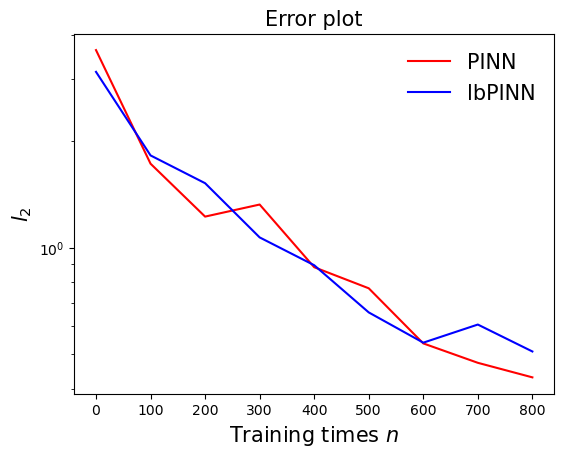

In [29]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1[:len(Step)],'r',label='PINN')
plt.semilogy(Step, T_error2,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

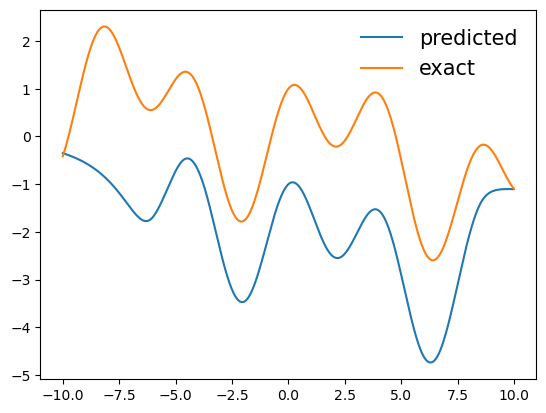

In [30]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [31]:
for epoch in range(900,5000):
    optimizer_weight.zero_grad() # to make the gradients zero
    
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = torch.exp(-weight.data[0])*mse_b + torch.exp(-weight.data[1])*mse_f + weight.data[0]+weight.data[1]
    

    
    loss.backward(retain_graph=True) # This is for computing gradients using backward propagation
    optimizer_weight.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    optimizer.zero_grad()
    loss = torch.exp(-weight.data[0])*mse_b + torch.exp(-weight.data[1])*mse_f 
    loss.backward()
    optimizer.step()
    
    loss_sum = mse_b+mse_f

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss_sum, mse_b,mse_f))
            print(weight)
            T_BC2.append(mse_b.detach().cpu().numpy())
            T_PDE2.append(mse_f.detach().cpu().numpy())
            T_error2.append(loss_sum.detach().cpu().numpy())
            Step.append(epoch)
            
            
    

[900]-th step loss: 0.3552,  BC: 0.00217, residual: 0.35304
tensor([0., 0.], device='cuda:0', requires_grad=True)
[1000]-th step loss: 0.2095,  BC: 0.00391, residual: 0.20562
tensor([0., 0.], device='cuda:0', requires_grad=True)
[1100]-th step loss: 0.1426,  BC: 0.00031, residual: 0.14226
tensor([0., 0.], device='cuda:0', requires_grad=True)
[1200]-th step loss: 0.1023,  BC: 0.00002, residual: 0.10225
tensor([0., 0.], device='cuda:0', requires_grad=True)
[1300]-th step loss: 0.0774,  BC: 0.00006, residual: 0.07736
tensor([0., 0.], device='cuda:0', requires_grad=True)
[1400]-th step loss: 0.0560,  BC: 0.00086, residual: 0.05512
tensor([0., 0.], device='cuda:0', requires_grad=True)
[1500]-th step loss: 0.0174,  BC: 0.00008, residual: 0.01734
tensor([0., 0.], device='cuda:0', requires_grad=True)
[1600]-th step loss: 0.0117,  BC: 0.00003, residual: 0.01171
tensor([0., 0.], device='cuda:0', requires_grad=True)
[1700]-th step loss: 0.0060,  BC: 0.00086, residual: 0.00509
tensor([0., 0.], dev

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1[:len(Step)],'r',label='PINN')
plt.semilogy(Step, T_error2,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [ ]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [ ]:
for epoch in range(5000,iterations):
    optimizer_weight.zero_grad() # to make the gradients zero
    
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = torch.exp(-weight.data[0])*mse_b + torch.exp(-weight.data[1])*mse_f + weight.data[0]+weight.data[1]
    

    
    loss.backward(retain_graph=True) # This is for computing gradients using backward propagation
    optimizer_weight.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    optimizer.zero_grad()
    loss = torch.exp(-weight.data[0])*mse_b + torch.exp(-weight.data[1])*mse_f 
    loss.backward()
    optimizer.step()
    
    loss_sum = mse_b+mse_f

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss_sum, mse_b,mse_f))
            print(weight)
            T_BC2.append(mse_b.detach().cpu().numpy())
            T_PDE2.append(mse_f.detach().cpu().numpy())
            T_error2.append(loss_sum.detach().cpu().numpy())
            Step.append(epoch)

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='PINN')
plt.semilogy(Step, T_error2,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [ ]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_BC2,'r',label=r'$loss_{BC}$')
plt.semilogy(Step, T_PDE2,'b',label=r'$loss_{PDE}$')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)